In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Activation functions

In [ ]:
''' Why do DL models need activation functions?
- We need some kind of nonlinearity between layers.
- What does it take to be a "good" activation function?

* Desired qualities in an activation function => for a hidden layer
- Nonlinearity
- Computationally simple
- Avoid limited range
- Avoid vanishing / exploding gradient

* Desired qualities in an activation function => for an output layer
- Nonlinearity (classify) or linear (regression)
- Boundaries of saturation that can be converted to probabilities, e.g., [0,1]

* Sigmoid
- Nearly linear
- Saturates at [0,1]
- Biased average
- Great for output

* Hyperbolic tangent
- Nearly linear in range
- Saturates at [-1, 1]
- Unbiased average
- OK for hidden

* ReLU
- Strongly nonlinear
- Never saturates
- Biased average
- Great for hidden

* ReLU variants
1) Leaky ReLU
- Strongly nonlinear
- Never saturates
- Less bias average
- Allows for neg. act.
- Typical alpha=.1

2) ReLU-N
- Strongly nonlinear
- Saturates
- Avoid blowing up
- Typical N=6
'''

In [ ]:
# variable to evaluate over
x = torch.linspace(-3,3,101)

# create a function that returns the activated output
def NNoutputx(actfun):
    # get activation function type
    # this code replaces torch.relu with torch.<actfun>
    actfun = getattr(torch, actfun)
    return actfun(x)

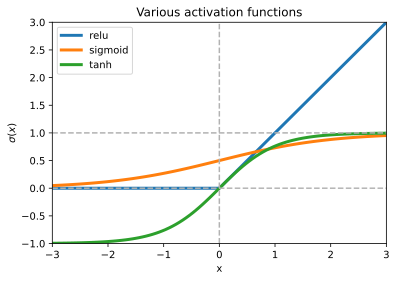

In [ ]:
# the activation functions
activation_funcs = ['relu', 'sigmoid', 'tanh']

fig = plt.figure(figsize=(6,4))

for actfun in activation_funcs:
    plt.plot(x, NNoutputx(actfun), label=actfun, linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]], [0,0], '--', color=dashlinecol)
plt.plot(x[[0,-1]], [1,1], '--', color=dashlinecol)
plt.plot([0,0],[-1,3], '--', color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()

## More activation functions in torch.nn

In [ ]:
# create a function that returns the activated output FUNCTION
# this is different from the previous function
def NNoutput(actfun):
    # get activation functiontype
    # this code replaces torch.nn.relu with torch.nn.<actfun>
    actfun = getattr(torch.nn, actfun)
    return actfun()

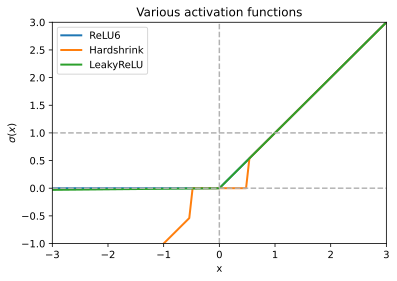

In [ ]:
# the activation functions
activation_funcs = ['ReLU6', 'Hardshrink', 'LeakyReLU']

fig = plt.figure(figsize=(6,4))

for actfun in activation_funcs:
    plt.plot(x, NNoutput(actfun)(x), label=actfun, linewidth=2)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]], [0,0], '--', color=dashlinecol)
plt.plot(x[[0,-1]], [1,1], '--', color=dashlinecol)
plt.plot([0,0],[-1,3], '--', color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()

## Differences between torch and torch.nn

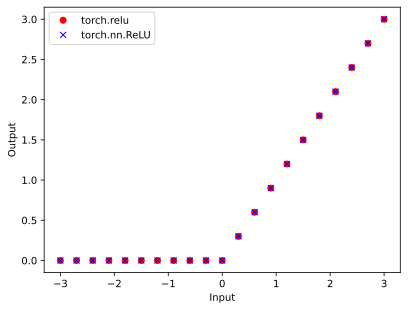

In [ ]:
# redefine x (fewer points to facilitate visualization)
x = torch.linspace(-3,3,21)

# in torch
y1 = torch.relu(x)

# in torch.nn
f = torch.nn.ReLU()
y2 = f(x)

# the results are the same
plt.plot(x, y1, 'ro', label='torch.relu')
plt.plot(x, y2, 'bx', label='torch.nn.ReLU')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

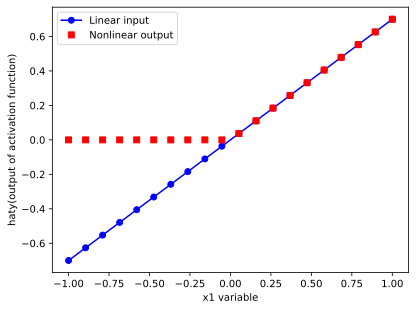

In [ ]:
# create input vectors
x1 = torch.linspace(-1,1,20)
x2 = 2*x1

# and corresponding weights
w1 = -.3
w2 = .5

# their linear combination
linpart = x1*w1 + x2*w2

# and the nonlinear output
y = torch.relu(linpart)

# and plot!
plt.plot(x1,linpart,'bo-',label='Linear input')
plt.plot(x1,y,'rs',label='Nonlinear output')
plt.ylabel('haty(output of activation function)')
plt.xlabel('x1 variable')
# plt.ylim([-.1,.1]) # optional -- uncomment and modify to zoom in
plt.legend()
plt.show()

# Activation functions comparison

## Import and process the data

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

# note: use the following lines to avoid the warning message
# qualThreshold = 5
# tmp = (data['quality']>qualThreshold).astype(int)
# data['boolQuality'] = tmp

<ipython-input-15-320c65f4ce84>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


## Re-organize the data: train/test in DataLoaders

In [ ]:
data_tensor = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Now for the DL part

In [ ]:
class ANNwine(nn.Module):
    def __init__(self, actfunc):
        super().__init__()

        self.input = nn.Linear(11,16)

        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        self.output = nn.Linear(32,1)

        # activation function to pass through
        self.actfunc = actfunc

    def forward(self, x):
        # get activation function type
        # this code replaces torch.relu with torch.<actfunc>
        actfunc = getattr(torch, self.actfunc)
        x = actfunc(self.input(x))
        x = actfunc(self.fc1(x))
        x = actfunc(self.fc2(x))
        return self.output(x)

In [ ]:
# test the model
# use sigmoid, relu, tanh
net = ANNwine('sigmoid')
net( torch.randn(10,11) ).shape

torch.Size([10, 1])

## Train the model

In [ ]:
numepochs = 1000

def trainTheModel(winenet):

    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        winenet.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = winenet(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    return trainAcc, testAcc, losses

In [ ]:
# list activation functions to test
activation_funcs = ['relu', 'tanh', 'sigmoid']

trainByAct = np.zeros((numepochs, len(activation_funcs)))
testByAct = np.zeros((numepochs, len(activation_funcs)))

for ai, actfunc in enumerate(activation_funcs):
    # create a model and train it
    winenet = ANNwine(actfunc)
    trainByAct[:,ai], testByAct[:,ai], losses = trainTheModel(winenet)

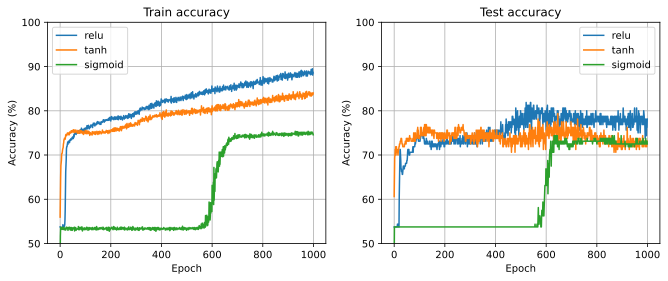

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
    ax[i].legend(activation_funcs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()

plt.show()

# Compare relu variants

## Now for the DL part

In [ ]:
class ANNwine(nn.Module):
    def __init__(self, actfunc):
        super().__init__()

        self.input = nn.Linear(11,16)

        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        self.output = nn.Linear(32,1)

        # activation function to pass through
        self.actfunc = actfunc

    def forward(self, x):
        # get activation function type
        # this code replaces torch.relu with torch.<self.actfunc>
        actfunc = getattr(torch.nn, self.actfunc)
        x = actfunc()( self.input(x) )
        x = actfunc()( self.fc1(x) )
        x = actfunc()( self.fc2(x) )
        return self.output(x)

In [ ]:
# test the model
# use sigmoid, relu, tanh
net = ANNwine('ReLU')
net( torch.randn(10,11) ).shape

torch.Size([10, 1])

## Train the model

In [ ]:
numepochs = 1000

def trainTheModel(winenet):

    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        winenet.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = winenet(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    return trainAcc, testAcc, losses

In [ ]:
# list activation functions to test
activation_funcs = ['ReLU', 'ReLU6', 'LeakyReLU']

trainByAct = np.zeros((numepochs, len(activation_funcs)))
testByAct = np.zeros((numepochs, len(activation_funcs)))

for ai, actfunc in enumerate(activation_funcs):
    # create a model and train it
    winenet = ANNwine(actfunc)
    trainByAct[:,ai], testByAct[:,ai], losses = trainTheModel(winenet)

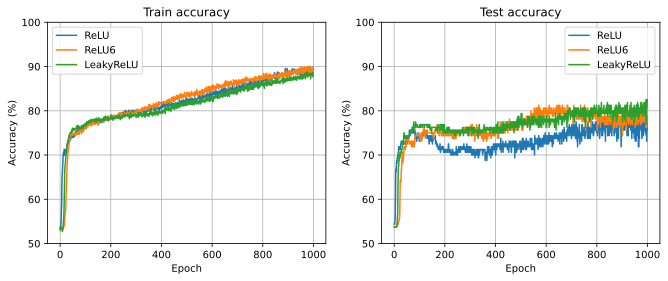

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
    ax[i].legend(activation_funcs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()

plt.show()

# Predict sugar

## Import and process the data

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

## Re-organize the data: train/test in DataLoaders

In [ ]:
cols2zscore = cols2zscore.drop('residual sugar')

data_tensor = torch.tensor(data[cols2zscore].values).float()
sugar = torch.tensor(data['residual sugar'].values).float()
sugar = sugar[:, None]

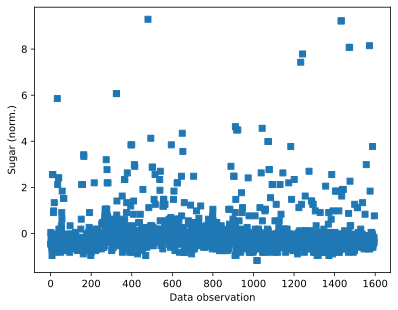

In [ ]:
# check values in sugar
plt.plot(sugar,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, sugar, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Now for the DL part

In [ ]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)

        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        self.output = nn.Linear(32,1)

    def forward(self,x):
        x = F.relu( self.input(x) )
        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        return self.output(x)

## Train the model

In [ ]:
numepochs = 1000

def trainTheModel():

    lossfunc = nn.MSELoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):
        winenet.train()

        batchLoss = []
        for X, y in train_loader:

            yHat = winenet(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testLoss[epochi] = lossfunc(yHat, y).item()

    return trainLoss, testLoss

In [ ]:
# create a model and train it
winenet = ANNwine()
trainLoss, testLoss = trainTheModel()

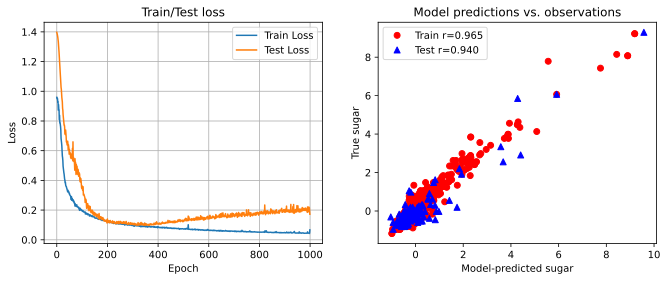

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLoss, label='Train Loss')
ax[0].plot(testLoss, label='Test Loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

# show prediction and real values
yHatTrain = winenet(train_data)
yHatTest = winenet(test_data)
ax[1].plot(yHatTrain.detach(), train_labels, 'ro')
ax[1].plot(yHatTest.detach(), test_labels, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlation between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T, train_labels.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}'])

plt.show()

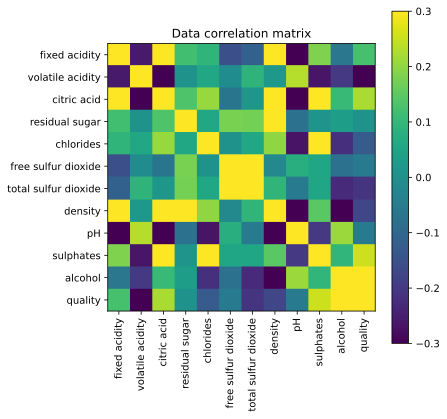

In [ ]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(6,6))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()


# Loss functions

In [ ]:
''' Mean-squared error (MSE)
- Use for continuous data when the output is a numerical prediction.
  e.g., height, hoouse price, temperature

Cross-entropy (logistic)
- Use for categorical data when the output is a probability.
  e.g., presence of disease, animal in picture, text sentiment

* Cross-entropy loss
1) Binary cross-entropy (BCE): Used for two possible answers.
2) Categorical cross-entropy, aka negative log-likelihood: Used with one-hot encoding.

* Kullback-Leibler divergence (KL distance)
- Measures the "distance" between two probability distributions.
'''

In [ ]:
''' Output layer architectures

* Predict continuous data:
- Output layer has one unit with linear activation function.
- MSE loss function.

* Binary classification:
- Output layer has one unit with sigmoid activation function.
- Cross-entropy (BCE) loss function.

* Multiclass (N-way) classification:
- Output layer has N units with softmax activation function.
- Cross-entropy (CCE) loss function.
'''

In [ ]:
''' Softmax vs. log-softmax
- Log-softmax: Compute softmax, then take log(p).
- Log-softmax increases the sensitivity at small probabilities.
- Log-softmax gives a stronger penalty for errors.
'''

## Mean-squared error

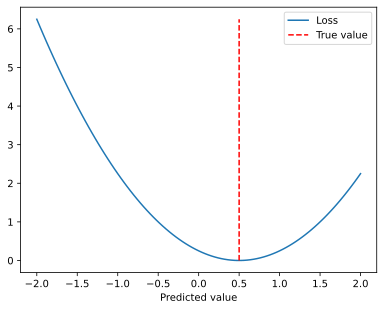

In [2]:
# loss function
lossfuncMSE = nn.MSELoss()

# create predictions and real answer
yHat = torch.linspace(-2,2,101)
y = torch.tensor(.5)

# compute MSE loss function
L = np.zeros(101)
for i, yy in enumerate(yHat):
    L[i] = lossfuncMSE(yy, y)

plt.plot(yHat, L, label='Loss')
plt.plot([y,y],[0, np.max(L)], 'r--', label='True value')
plt.xlabel('Predicted value')
plt.legend()
plt.show()

## Binary cross-entropy

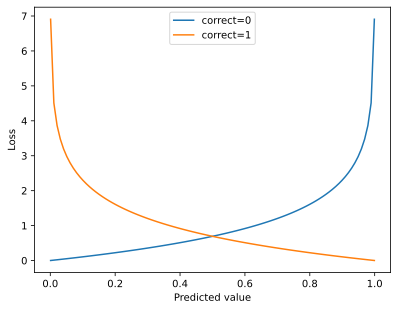

In [6]:
# loss function
lossfuncBCE = nn.BCELoss()

# create predictions and real answer
yHat = torch.linspace(.001, .999, 101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

# compute MSE loss function
L = np.zeros((101,2))
for i, yy in enumerate(yHat):
    L[i,0] = lossfuncBCE(yy, y1)    # 0 is the correct answer
    L[i,1] = lossfuncBCE(yy, y2)    # 1 is the correct answer

plt.plot(yHat, L)
plt.xlabel('Predicted value')
plt.ylabel('Loss')
plt.legend(['correct=0', 'correct=1'])
# plt.yscale('log')
plt.show()

In [8]:
# The example above shows data already in probabilities. Raw outputs will need to be converted to probabilies

# "raw" output of a model
yHat = torch.tensor(2.)
# print(lossfuncBCE(yHat, y2))

# convert to prob via sigmoid
sig = nn.Sigmoid()
print(lossfuncBCE( sig(yHat), y2) )

tensor(0.1269)


In [9]:
# However, PyTorch recommends using a single function that incorporates sigmoid+BCE due to increased numerical stability.

# Thus, the recommended way to do it:
lossfuncBCE = nn.BCEWithLogitsLoss()
yHat = torch.tensor(2.)
print(lossfuncBCE(yHat, y2))

tensor(0.1269)


## Categorical cross-entropy

In [11]:
# loss function
lossfuncCCE = nn.CrossEntropyLoss()

# vector of output layer (pre-softmax)
yHat = torch.tensor([[1.,4,3]])

for i in range(3):
    correctAnswer = torch.tensor([i])
    thisloss = lossfuncCCE(yHat, correctAnswer).item()
    print('Loss when correct answer is %g: %g' %(i, thisloss))

Loss when correct answer is 0: 3.34901
Loss when correct answer is 1: 0.349012
Loss when correct answer is 2: 1.34901


In [13]:
# compare raw, softmax, and log-softmax outputs
sm = nn.Softmax(dim=1)
yHat_sm = sm(yHat)

sm = nn.LogSoftmax(dim=1)
yHat_logsm = sm(yHat)

print(yHat)
print(yHat_sm)
print(yHat_logsm)

tensor([[1., 4., 3.]])
tensor([[0.0351, 0.7054, 0.2595]])
tensor([[-3.3490, -0.3490, -1.3490]])


## Creating your own custom loss function

In [14]:
class myLoss(nn.Module):        # inherent info from nn.Module
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = torch.abs(x-y)
        return loss

In [15]:
# test it out!
lfunc = myLoss()
lfunc(torch.tensor(4), torch.tensor(5.2))

tensor(1.2000)

# Multi-output ANNs

## Create and inspect the data

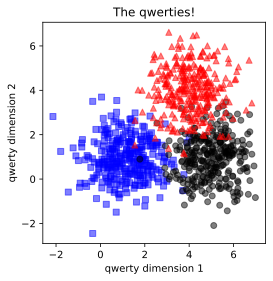

In [16]:
# create data
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,4]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((
    np.zeros((nPerClust)),
    np.ones((nPerClust)),
    1+np.ones((nPerClust))
))

# concatenate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs', alpha=.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko', alpha=.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], 'r^', alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [18]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize=16
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [19]:
# how many batches are there?
print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


## Create and validate the model

In [20]:
# create a class for the model
def createTheQwertyNet():

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2,8)

            # hidden layer
            self.hidden = nn.Linear(8,8)

            # output layer
            self.output = nn.Linear(8,3)

        def forward(self, x):
            x = F.relu( self.input(x) )
            x = F.relu( self.hidden(x) )
            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [21]:
# test the model with fake input
net, lossfunc, optimizer = createTheQwertyNet()
print(net)

# input is ten samples
input = torch.rand(10,2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (hidden): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[ 0.4442, -0.0257,  0.1787],
        [ 0.4412, -0.0229,  0.1758],
        [ 0.4418, -0.0031,  0.1796],
        [ 0.4404, -0.0221,  0.1752],
        [ 0.4320, -0.0205,  0.1671],
        [ 0.4402, -0.0459,  0.2068],
        [ 0.4350, -0.0070,  0.1723],
        [ 0.4368,  0.0018,  0.1755],
        [ 0.4148, -0.0106,  0.1578],
        [ 0.4397, -0.0466,  0.2092]], grad_fn=<AddmmBackward0>)

## A function that trains the model

In [22]:
def function2trainTheModel():

    numepochs = 100

    # create a new model
    net, lossfunc, optimizer = createTheQwertyNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        net.train()

        # loop over training data batches
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y                   # boolean (false/true)
            matchesNumeric = matches.float()                                 # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)       # average and x100
            batchAcc.append( accuracyPct.item() )                          # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():               # deactivates autograd
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
    # end epochs

    # function output
    return trainAcc, testAcc, losses, net

## Run the model and plot the results

In [23]:
# run the model
trainAcc, testAcc, losses, net = function2trainTheModel()

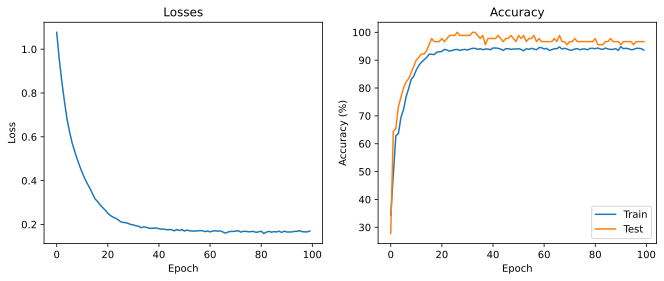

In [24]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

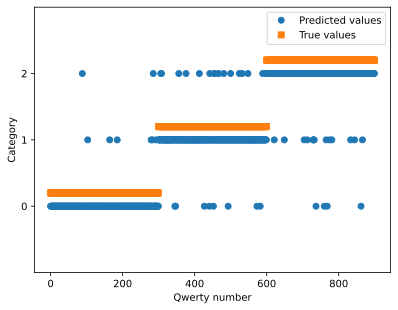

In [25]:
# run the data through the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat, axis=1)

# and plot those against the real data
plt.plot(predictions, 'o', label='Predicted values')
plt.plot(labels+.2, 's', label='True values')
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()

plt.show()

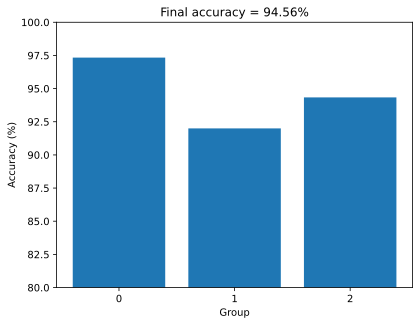

In [26]:
# recode each prediction by accuracy
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100 * accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
    accuracyByGroup[i] = 100 * torch.mean(accuracy[labels==i])

plt.bar(range(3), accuracyByGroup)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final accuracy = {totalAcc:.2f}%')

plt.show()

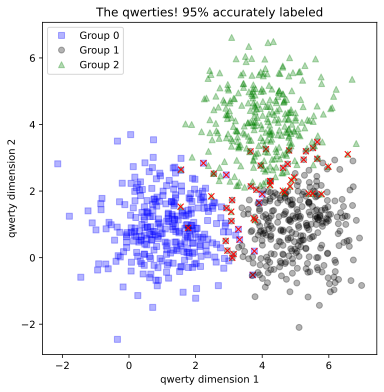

In [27]:
# Finally, show the qwerties in their native space, labeled by accuracy

# data markers
colorShapes = ['bs', 'ko', 'g^']

# show the data
fig = plt.figure(figsize=(6,6))

# plot correct and incorrect labeled data
for i in range(3):
    # plot all data points for this label
    plt.plot(data[labels==i, 0], data[labels==i, 1], colorShapes[i], alpha=.3, label=f'Group {i}')

    # cross out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    plt.plot(data[idxErr, 0], data[idxErr, 1], 'rx')

plt.title(f'The qwerties! {totalAcc:.0f}% accurately labeled')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

# Optimizers (minibatch, momentum)

In [27]:
'''What and where are optimizers?
- "Optimizer" refers to the algorithm that adjusts the weights during backprop.
- You already know about SGD.
- Other optimizers are simply modifications of SGD, with the goal of smoothing the descent.

* SGD: Change the weights after each sample. This is great when all samples are really similar to each other.
- But SGD learning is very sensitive, and can lead to volatile changes based on non-representative samples.

* Mini-batch SGD: Change the weights after N samples. Average losses across the N samples.
- Sometimes more robust than SGD, except when samples are similar to each other.

* What is "momentum"?
- Smoothing via weighted averaging.
- Each data point is a weighted combination of itself and the previous data point.

* SGD with momentum
- Inpterpretation: Update current weights according to a weighted average of current and previous costs.
- Typical values of beta are .9 to .99.

* Why do they call it "momentum"?
- Geometric interpretation: weight trajectory is biased by previous direction.
- The particle builds momentum as it moves along the error surface.
'''

# SGD with momentum

## Data

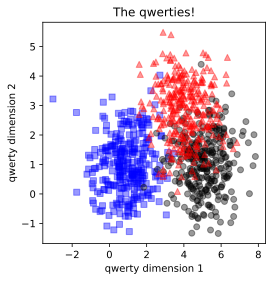

In [30]:
# create data
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,3]

a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur ]

labels_np = np.hstack((
    np.zeros((nPerClust)),
    np.ones((nPerClust)),
    1+np.ones((nPerClust))
))

data_np = np.hstack((a,b,c)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs', alpha=.4)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko', alpha=.4)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], 'r^', alpha=.4)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [32]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=16
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Model

In [33]:
# create a class for the model
def createTheQwertyNet(momentum):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.hidden = nn.Linear(8,8)
            self.output = nn.Linear(8,3)

        def forward(self, x):
            x = F.relu( self.input(x) )
            x = F.relu( self.hidden(x) )
            return self.output(x)

    net = qwertyNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=momentum)

    return net, lossfunc, optimizer

In [35]:
# confirm that the optimizer has momentum
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## Training

In [36]:
# a function that trains the model

numepochs = 50

def function2trainTheModel(momentum):

    # create a new model
    net, lossfunc, optimizer = createTheQwertyNet(momentum)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct.item())

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Now for the experiment!

In [42]:
# momentum values to use
# momenta = [0,.5, .9, .95,.999]
momenta = [0,.5, .9, .95]

# initialize results matrix
results = np.zeros((numepochs, len(momenta), 3))

# test all momentum values on the same data (different model instances)
for idx, mom in enumerate(momenta):
    trainAcc, testAcc, losses, net = function2trainTheModel(mom)
    results[:,idx,0] = losses
    results[:,idx,1] = trainAcc
    results[:,idx,2] = testAcc

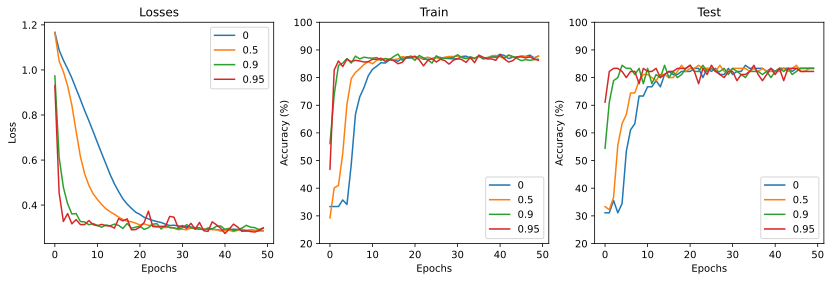

In [44]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

for i in range(3):
    ax[i].plot(results[:,:,i])
    ax[i].legend(momenta)
    ax[i].set_xlabel('Epochs')
    if i == 0:
        ax[i].set_ylabel('Loss')
    else:
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

# Optimizers (RMSprop, Adam)

In [44]:
''' RMSprop
- RMS = root-mean-square (prop = propagation).
- Similar concept as momentum: Bias the weight changes using dampened previous gradients.
- RMSprop solution: Instead of biasing the gradient, bias the learning rate according to the magnitude of the gradient.

- Key point: The step size for adjusting the weight depends on the history of the gradient magnitudes.
- Large gradients -> smaller step / Small gradients -> larger step
- Large gradients indicate oscillations or volatile learning.

- Implications: Remember that the gradient stores the partial derivatives along each direction,
  so RMSprop adjusts the learning rate for each direction (each weight!).
- RMSprop is less affected by the initial learning rate choice, and automatically implements learning rate decay (cf. vanilla SGD).

* Adam (Adaptive momentum)
- combine momentum and RMSprop.
'''

# Optimizers comparison

## The model

In [45]:
def createTheQwertyNet(optimizerAlgo):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.hidden = nn.Linear(8,8)
            self.output = nn.Linear(8,3)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden(x))
            return self.output(x)

    net = qwertyNet()
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optifunc = getattr(torch.optim, optimizerAlgo)
    optimizer = optifunc(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [47]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('RMSprop')[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

## A function that trains the model

In [48]:
def function2trainTheModel(optimizerType):

    numepochs = 50

    net, lossfunc, optimizer = createTheQwertyNet(optimizerType)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct.item())

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## A function that plots the results

In [50]:
def plotTheResults(optimizerType):

    # compute accuracy over entire dataset
    yHat = net(data)
    prdictions = torch.argmax(yHat, axis=1)
    accuracy = (predictions == labels).float()
    total_acc = torch.mean(accuracy*100).item()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100 * torch.mean(accuracy[labels==i])

    # create the figure
    fig, ax = plt.subplots(2,2,figsize=(9,6))

    # plot the loss function
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('Epoch')
    ax[0,0].set_title(f'{optimizerType}: Losses')

    # plot the accuracy functions
    ax[0,1].plot(trainAcc, label='Train')
    ax[0,1].plot(testAcc, label='Test')
    ax[0,1].set_ylabel('Accuracy (%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title(f'{optimizerType}: Accuracy')
    ax[0,1].legend()

    # plot overall accuracy by group
    ax[1,0].bar(range(3), accuracyByGroup)
    ax[1,0].set_ylim([np.min(accuracyByGroup)-5, np.max(accuracyByGroup)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_ylabel('Accuracy (%)')
    ax[1,0].set_title(f'{optimizerType}: Accuracy by group')

    # scatterplot of correct and incorrect labeled data
    colorShapes = ['bs', 'ko', 'g^']
    for i in range(3):
        # plot all data points
        ax[1,1].plot(data[labels==i, 0], data[labels==i, 1], colorShapes[i], alpha=.4, label=f'Group {i}')

        # cross-out the incorrect ones
        idxErr = (accuracy==0) & (labels==i)
        ax[1,1].plot(data[idxErr, 0], data[idxErr, 1], 'rx')

    ax[1,1].set_title(f'{optimizerType}: Total accuracy: {total_acc:.2f}%')
    ax[1,1].set_xlabel('qwerty dimension 1')
    ax[1,1].set_ylabel('qwerty dimension 2')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

## Now for the optimizer comparison

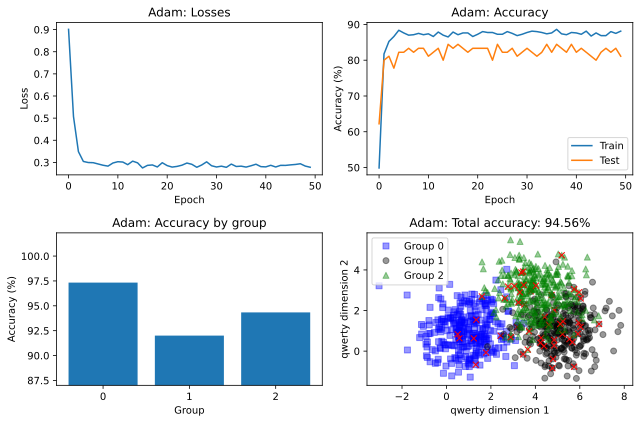

In [51]:
# run the model for one optimizer
optimizerType = 'Adam'
trainAcc, testAcc, losses, net = function2trainTheModel(optimizerType)

# visualize!
plotTheResults(optimizerType)

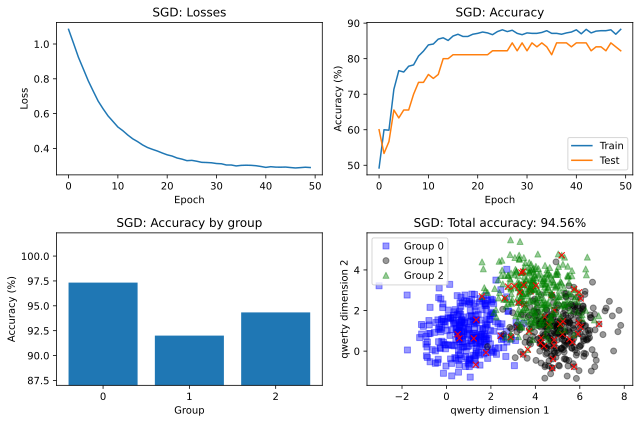

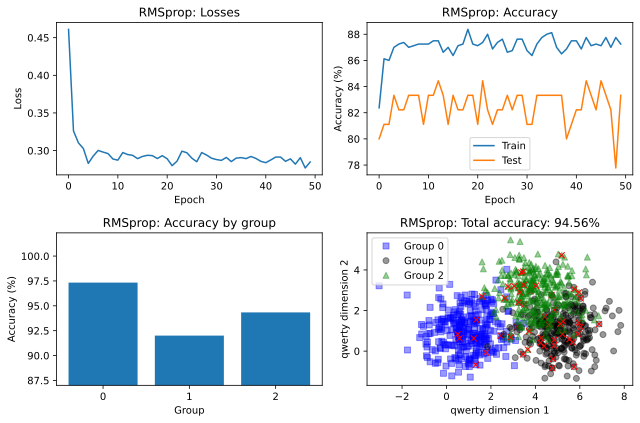

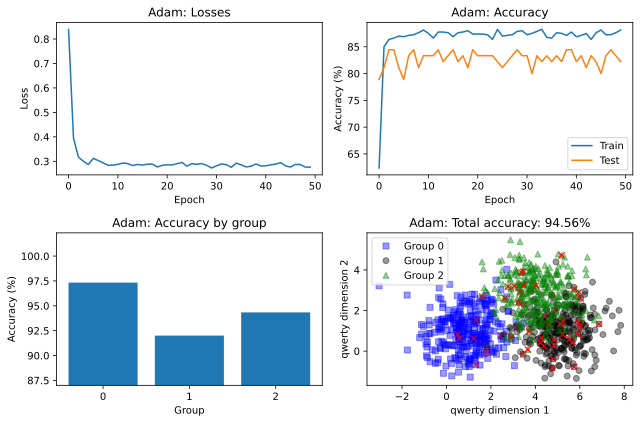

In [52]:
# now run through all of them

# average performance
performance = []

for opto in ['SGD', 'RMSprop', 'Adam']:
    trainAcc, testAcc, losses, net = function2trainTheModel(opto)
    plotTheResults(opto)

    # store the final results
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])

    performance.append(f'{opto} train {train:.1f}%, test {test:.1f}%')

In [54]:
performance

['SGD train 87.7%, test 83.4%',
 'RMSprop train 87.3%, test 82.6%',
 'Adam train 87.4%, test 82.6%']

# Optimizers and ... something

## Model

In [55]:
def createTheQwertyNet(optimizerAlgo, learningrate):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.hidden = nn.Linear(8,8)
            self.output = nn.Linear(8,3)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden(x))
            return self.output(x)

    net = qwertyNet()
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optifunc = getattr(torch.optim, optimizerAlgo)
    optimizer = optifunc(net.parameters(), lr=learningrate)

    return net, lossfunc, optimizer

## Training

In [56]:
def function2trainTheModel(optimizerType, learningrate):

    numepochs = 50

    net, lossfunc, optimizer = createTheQwertyNet(optimizerType, learningrate)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Experiment

In [58]:
# variables to loop over
learningRates = np.logspace(np.log10(.0001), np.log10(.1), 20)
optimTypes = ['SGD', 'RMSprop', 'Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates), len(optimTypes)))

# now for the experiment!
for idx_o, opto in enumerate(optimTypes):
    for idx_l, lr in enumerate(learningRates):
        trainAcc, testAcc, losses, net = function2trainTheModel(opto, lr)
        finalPerformance[idx_l, idx_o] = np.mean(testAcc[-10:])

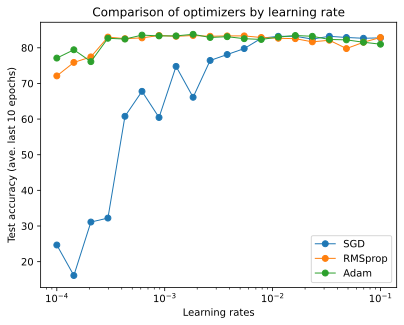

In [59]:
# plot the results!
plt.plot(learningRates, finalPerformance, 'o-', linewidth=1)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

In [60]:
learningRates

array([0.0001    , 0.00014384, 0.00020691, 0.00029764, 0.00042813,
       0.00061585, 0.00088587, 0.00127427, 0.00183298, 0.00263665,
       0.00379269, 0.00545559, 0.0078476 , 0.01128838, 0.01623777,
       0.02335721, 0.03359818, 0.0483293 , 0.06951928, 0.1       ])

# Adam with L2 regularization

In [61]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Model

In [62]:
def createTheQwertyNet(L2lambda):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.hidden = nn.Linear(8,8)
            self.output = nn.Linear(8,3)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden(x))
            return self.output(x)

    net = qwertyNet()
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=L2lambda)

    return net, lossfunc, optimizer

## Training

In [63]:
def function2trainTheModel(L2lambda):

    net, lossfunc, optimizer = createTheQwertyNet(L2lambda)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossfunc(yHat, y)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Experiment

In [64]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,6)

# number of epochs
numepochs = 50

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(l2lambdas)))

# loop over l2ldmabdas
for li in range(len(l2lambdas)):

    # create and train a model
    trainAcc, testAcc, losses, net = function2trainTheModel(l2lambdas[li])

    # store results
    accuracyResultsTrain[:, li] = trainAcc
    accuracyResultsTest[:, li] = testAcc

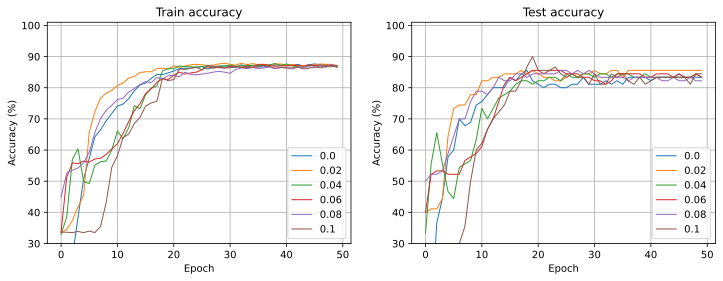

In [65]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(accuracyResultsTrain, linewidth=1)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest, linewidth=1)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i, 2) for i in l2lambdas]

for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([30,101])
    ax[i].grid()

plt.show()

# Learning rate decay

In [84]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=16
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## The model

In [85]:
def createTheQwertyNet(initialLR):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.hidden = nn.Linear(8,8)
            self.output = nn.Linear(8,3)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden(x))
            return self.output(x)

    net = qwertyNet()
    lossfunc = nn.CrossEntropyLoss()

    # optimizer and LR scheduler
    optimizer = torch.optim.SGD(net.parameters(), lr=initialLR)
    stepsize = batchsize * len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=.5)

    return net, lossfunc, optimizer, scheduler

In [86]:
# how many steps until the learning rate changes?
len(train_loader) * batchsize

800

## Explore the learning rate decay parameter

In [69]:
# create a network
net = createTheQwertyNet(.01)[0]

# a new optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/2)

# test the change in learning rate
for epoch in range(3):
    for batchnum in range(10):
        print(f'Batch {batchnum}, epoch {epoch} : LR={scheduler.get_last_lr()[0]}')
        scheduler.step()

Batch 0, epoch 0 : LR=0.01
Batch 1, epoch 0 : LR=0.01
Batch 2, epoch 0 : LR=0.01
Batch 3, epoch 0 : LR=0.01
Batch 4, epoch 0 : LR=0.01
Batch 5, epoch 0 : LR=0.005
Batch 6, epoch 0 : LR=0.005
Batch 7, epoch 0 : LR=0.005
Batch 8, epoch 0 : LR=0.005
Batch 9, epoch 0 : LR=0.005
Batch 0, epoch 1 : LR=0.0025
Batch 1, epoch 1 : LR=0.0025
Batch 2, epoch 1 : LR=0.0025
Batch 3, epoch 1 : LR=0.0025
Batch 4, epoch 1 : LR=0.0025
Batch 5, epoch 1 : LR=0.00125
Batch 6, epoch 1 : LR=0.00125
Batch 7, epoch 1 : LR=0.00125
Batch 8, epoch 1 : LR=0.00125
Batch 9, epoch 1 : LR=0.00125
Batch 0, epoch 2 : LR=0.000625
Batch 1, epoch 2 : LR=0.000625
Batch 2, epoch 2 : LR=0.000625
Batch 3, epoch 2 : LR=0.000625
Batch 4, epoch 2 : LR=0.000625
Batch 5, epoch 2 : LR=0.0003125
Batch 6, epoch 2 : LR=0.0003125
Batch 7, epoch 2 : LR=0.0003125
Batch 8, epoch 2 : LR=0.0003125
Batch 9, epoch 2 : LR=0.0003125


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## Training

In [87]:
def function2trainTheModel(initialLR, toggleDynamicLR):

    numepochs = 50

    net, lossfunc, optimizer, scheduler = createTheQwertyNet(initialLR)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    currentLR = []

    for epochi in range(numepochs):

        net.train()

        batchLoss = []
        batchAcc = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step the learning-rate scheduler
            if toggleDynamicLR:
                scheduler.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

            currentLR.append( scheduler.get_last_lr()[0] )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, currentLR, net

## Test that the model really changes (sanity checks)

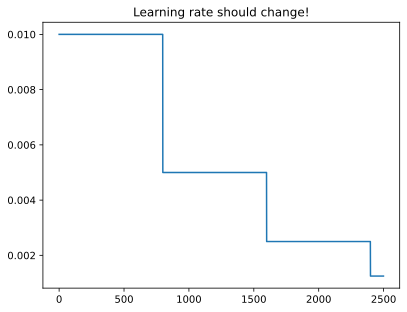

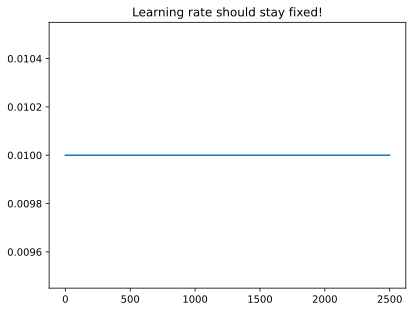

In [88]:
# test that the learning rate is really working
trainAcc, testAcc, losses, currentLR, net = function2trainTheModel(.01, True)
plt.plot(currentLR)
plt.title('Learning rate should change!')
plt.show()

trainAcc, testAcc, losses, currentLR, net = function2trainTheModel(.01, False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed!')
plt.show()

## Now for the experiment!

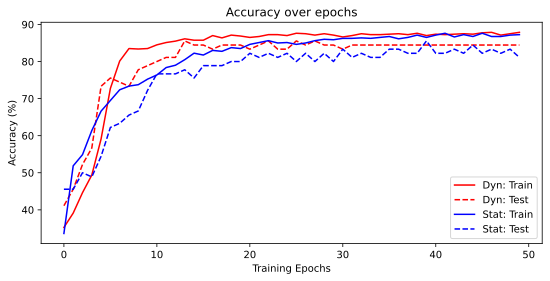

In [89]:
# now test with and without dynamic LR
trainAccDynamic, testAccDynamic, losses, currentLR, net = function2trainTheModel(.01, True)
trainAccStatic, testAccStatic, losses, currentLR, net = function2trainTheModel(.01, False)

fig = plt.figure(figsize=(9,4))
plt.plot(trainAccDynamic, 'r', label='Dyn: Train')
plt.plot(testAccDynamic, 'r--', label='Dyn: Test')

plt.plot(trainAccStatic, 'b', label='Stat: Train')
plt.plot(testAccStatic, 'b--', label='Stat: Test')

plt.xlabel('Training Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# How to pick the right metaparameters

In [ ]:
''' Most important: Do what others have done (with similar architecture, data, problem, etc.).
Use knowledge that you've built up from experience (that's why we test MANY models).
Random search is usually more fruitful than grid-search.
Try to balance laziness and diligence.
'''